In [ ]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from text_dataset import TinyStoriesDataset
seq_length = 128
batch_size = 64
raw_dataset = load_dataset("roneneldan/TinyStories")
# 假设数据集中每个样本包含 "text" 字段，这里我们只使用训练集
texts = [sample["text"] for sample in raw_dataset["train"]]

# Determine device
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")


# 检查词表大小
print("Vocabulary size:", len(tokenizer.get_vocab()))

dataset = TinyStoriesDataset(texts, tokenizer, seq_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=16)

In [ ]:
print(len(dataloader))

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        # Linear projections for Q, K, V, and output
        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.o_proj = nn.Linear(d_model, d_model)

    def _transpose_score(self, x): # x shape: [B, seq_len, d_model]
        new_shape = x.size()[:-1] + (self.num_heads, self.d_k)
        x = x.view(*new_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, q, k, v, mask=None):
        # Linear projections for Q, K, V
        Q = self._transpose_score(self.q_proj(q))
        K = self._transpose_score(self.k_proj(k))
        V = self._transpose_score(self.v_proj(v))

        # Scaled dot-product attention
        scores = Q @ K.transpose(-2, -1) / math.sqrt(self.d_k)

        # Apply mask
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        # Softmax to get attention weights
        attn_weights = F.softmax(scores, dim=-1)

        # Apply attention weights to V
        context = attn_weights @ V # shape: [B, num_heads, seq_len, d_k]

        # reshape back to [B, seq_len, num_heads * d_k]
        context = context.permute(0, 2, 1, 3).contiguous().view(*q.size())
        output = self.o_proj(context)
        return output


In [ ]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.fc2(F.relu(self.fc1(x)))

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_len=5000):
        super().__init__()

        # Create a matrix for positional encodings
        pe = torch.zeros(max_seq_len, d_model)
        position = torch.arange(0, max_seq_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0)) # shape: [1, max_seq_len, d_model]

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.0):
        super().__init__()
        
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionwiseFeedForward(d_model, d_ff)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask):
        # self-attention
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout1(attn_output)) # residual connectionand layer normalization 

        # feed-forward
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout2(ff_output))

        return x

In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.0):
        super().__init__()

        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionwiseFeedForward(d_model, d_ff)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask=None, tgt_mask=None):
        # self-attention
        self_attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout1(self_attn_output))

        # cross-attention
        cross_attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout2(cross_attn_output))

        # feed-forward
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout3(ff_output))

        return x

In [ ]:
class Encoder(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, num_layers, dropout=0.0):
        super().__init__()

        self.layers = nn.ModuleList([
            EncoderBlock(d_model, num_heads, d_ff, dropout) 
            for _ in range(num_layers)
        ])

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return x

In [ ]:
class Decoder(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, num_layers, dropout=0.0):
        super().__init__()
    
        self.layers = nn.ModuleList([
            DecoderBlock(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, enc_output, src_mask=None, tgt_mask=None):
        for layer in self.layers:
            x = layer(x, enc_output, src_mask, tgt_mask)
        return x

In [ ]:
class Transformer(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, d_ff, num_layers, dropout=0.0):
        super().__init__()
        self.d_model = d_model

        # Embedding layers
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model)

        # Decoder
        self.decoder = Decoder(d_model, num_heads, d_ff, num_layers, dropout)

        # Output projection
        self.fc = nn.Linear(d_model, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        x = self.embedding(x) * math.sqrt(self.d_model)
        x = self.positional_encoding(x)
        x = self.dropout(x)

        # Pass through decoder
        x = self.decoder(x, x, None, mask)
        output = self.fc(x)

        return output

In [ ]:
def create_causal_mask(seq_len):
    """Create a causal attention mask to prevent attending to future tokens."""
    mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1)
    return mask == 0

In [ ]:
class SimpleTokenizer:
    def __init__(self, texts=None):
        self.char_to_idx = {}
        self.idx_to_char = {}

        if texts:
            self.fit(texts)
    
    def fit(self, texts):
        unique_chars = set()
        for text in texts:
            unique_chars.update(text)
            
        self.char_to_idx = {char: idx for idx, char in enumerate(unique_chars)}
        self.idx_to_char = {idx: char for char, idx in self.char_to_idx.items()}

    def encode(self, text):
        return [self.char_to_idx[char] for char in text]

    def decode(self, indices):
        return ''.join([self.idx_to_char[idx] for idx in indices])
    
    @property
    def vocab_size(self):
        return len(self.char_to_idx)

In [ ]:
from torch.utils.data import Dataset

class TextDataset(Dataset):
    def __init__(self, texts, tokenizer, seq_length):
        self.tokenizer = tokenizer
        self.seq_length = seq_length
        self.data = []
        for text in texts:
            token_ids = tokenizer.encode(text)
            # 如果文本长度不足一个序列则跳过
            if len(token_ids) < seq_length + 1:
                continue
            # 使用滑动窗口生成 (input, target) 对，每个序列长度为 seq_length
            for i in range(0, len(token_ids) - seq_length):
                self.data.append(token_ids[i:i+seq_length+1])
                
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        tokens = self.data[idx]
        # 输入为前 seq_length 个 token，目标为后 seq_length 个 token（右移一个位置）
        input_ids = torch.tensor(tokens[:-1], dtype=torch.long)
        target_ids = torch.tensor(tokens[1:], dtype=torch.long)
        return input_ids, target_ids
    
# class TextDataset(Dataset):
#     def __init__(self, texts, tokenizer, seq_length):
#         self.tokenizer = tokenizer
#         self.seq_length = seq_length
#         self.texts = texts

#         self.data = []
#         for text in texts:
#             self.data.extend(tokenizer.encode(text))
        
#         self.num_sequences = max(0, len(self.data) - seq_length)

#     def __len__(self):
#         return self.num_sequences
    
#     def __getitem__(self, idx):
#         input_seq = self.data[idx:idx + self.seq_length]
#         target_seq = self.data[idx + 1: idx + self.seq_length + 1]
#         return (
#             torch.tensor(input_seq, dtype=torch.long),
#             torch.tensor(target_seq, dtype=torch.long)
#         )

In [ ]:
def train_transformer(model, dataloader, num_epochs, lr, device):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            seq_len = inputs.size(1)
            causal_mask = create_causal_mask(seq_len).to(device)

            optimizer.zero_grad()
            outputs = model(inputs, causal_mask)
            loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1)) # reshape for CrossEntropyLoss: (Batch * seqlen, vocab_size)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs} Loss: {total_loss:.4f} LR: {current_lr:.6f}")

In [ ]:
def generate_text(model, tokenizer, start_text, max_length, temperature=1.0, device='cpu'):
    model.eval()

    input_seq = tokenizer.encode(start_text)
    input_tensor = torch.tensor([input_seq], dtype=torch.long).to(device)

    for _ in range(max_length):
        seq_len =  input_tensor.size(1)
        causal_mask = create_causal_mask(seq_len).to(device)

        with torch.no_grad():
            output = model(input_tensor, causal_mask)
        
        next_token_logits = output[0, -1, :] / temperature

        probabilities = F.softmax(next_token_logits, dim=-1)
        next_token = torch.multinomial(probabilities, 1).item()

        input_tensor = torch.cat([
            input_tensor,
            torch.tensor([[next_token]], dtype=torch.long).to(device)
        ], dim=1)
    
    generate_tokens = input_tensor[0].tolist()
    generate_text = tokenizer.decode(generate_tokens)
    return generate_text


In [ ]:
# Hyperparameters
seq_length = 128
batch_size = 64
d_model = 64
num_heads = 4
d_ff = 256
num_layers = 2
dropout = 0.1
num_epochs = 100
lr = 1e-3

In [ ]:
from datasets import load_dataset

raw_dataset = load_dataset("roneneldan/TinyStories")
# 假设数据集中每个样本包含 "text" 字段，这里我们只使用训练集
texts = [sample["text"] for sample in raw_dataset["train"]]

In [ ]:
# Determine device
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize tokenizer
tokenizer = SimpleTokenizer(texts)
print(f"Vocabulary size: {tokenizer.vocab_size}")

In [ ]:
from torch.utils.data import DataLoader
dataset = TextDataset(texts, tokenizer, seq_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=16)


In [1]:
# Hyperparameters
seq_length = 512
batch_size = 64
d_model = 512
num_heads = 8
d_ff = d_model * 4
num_layers = 6
dropout = 0.1
# num_epochs = 20
max_steps = 100000
lr = 1e-3


In [3]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")


In [4]:
from transformer import Transformer

model = Transformer(
    vocab_size=tokenizer.vocab_size,
    d_model=d_model,
    num_heads=num_heads,
    d_ff=d_ff,
    num_layers=num_layers,
    dropout=dropout
)

In [5]:
from training import generate_text
import torch
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load("transformer_step_5000.pth")['model_state_dict'])
model = model.to(device)

/tmp/ipykernel_1033478/2428366304.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("transformer_step_5000.pth")['model_state_dict'])


In [15]:
# Generate text
start_text = "GPT-o3 pro is "
generated_text = generate_text(model, tokenizer, start_text, max_length=256, temperature=0.1, device=device)
print(f"Generated text:\n{generated_text}")

Generated text:
GPT - o3 pro is a little girl. She likes to explore and learn new things. One day, she finds a big box. Inside was a shiny stone. She was so excited and wanted to keep it. She put the stone in her pocket and took it home. When she got home, she showed her mom the stone. Her mom said, " That stone is very special. It is a stone. " Kara was so happy and she hugged it tightly. She knew she could keep it forever. [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

In [7]:
from datasets import load_dataset
from text_dataset import TinyStoriesDataset
from torch.utils.data import DataLoader
raw_dataset = load_dataset("roneneldan/TinyStories")
# 假设数据集中每个样本包含 "text" 字段，这里我们只使用训练集
texts = [sample["text"] for sample in raw_dataset["train"]]

split_idx = int(0.9 * len(texts))
train_texts = texts[:split_idx]
val_texts = texts[split_idx:]


device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

train_dataset = TinyStoriesDataset(train_texts, tokenizer, seq_length)
val_dataset = TinyStoriesDataset(val_texts, tokenizer, seq_length)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=16)


KeyboardInterrupt: 

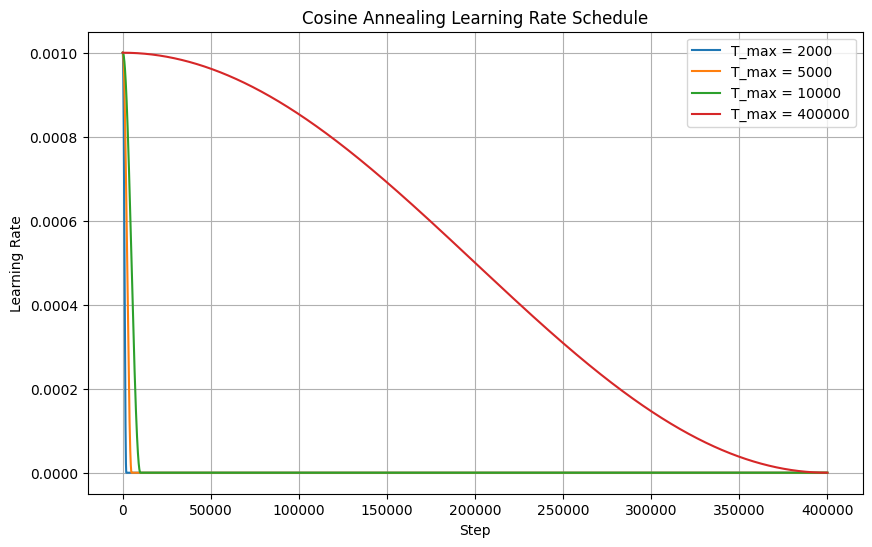

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math

# 参数设置
initial_lr = 0.001     # 初始学习率（eta_max）
eta_min = 0.0          # 最低学习率
total_steps = 400000    # 总步数，用于绘图
T_max_list = [2000, 5000, 10000, 400000]  # 不同的 T_max 值

steps = np.arange(total_steps)

plt.figure(figsize=(10, 6))

for T_max in T_max_list:
    # 计算每一步的学习率：超过 T_max 后保持在 eta_min
    lr_schedule = [eta_min + 0.5 * (initial_lr - eta_min) *
                   (1 + math.cos(math.pi * min(step, T_max) / T_max))
                   for step in steps]
    plt.plot(steps, lr_schedule, label=f"T_max = {T_max}")

plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Cosine Annealing Learning Rate Schedule")
plt.legend()
plt.grid(True)
plt.show()
